Final Project
Predict whether a mammogram mass is benign or malignant
We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

BI-RADS assessment: 1 to 5 (ordinal)
Age: patient's age in years (integer)
Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
Severity: benign=0 or malignant=1 (binominal)
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

Your assignment
Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

Decision tree
Random forest
KNN
Naive Bayes
SVM
Logistic Regression
And, as a bonus challenge, a neural network using Keras.
The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!

In [1]:
import pandas as pd
import numpy as np

from IPython.display import Image  
from sklearn import tree, svm
from sklearn.externals.six import StringIO
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from itertools import cycle
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import pydotplus
import pylab as pl
from pylab import *

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Let's begin: prepare your data
Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.
"""
dataFile = 'mammographic_masses.data.txt'
labelFile = 'mammographic_masses.names.txt'

r_cols = ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity']
testResultsDF = pd.read_csv(dataFile, na_values=['?'], names=r_cols,)
testResultsDF.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [3]:
# Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.
testResultsDF.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [4]:
testResultsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
BI_RADS     959 non-null float64
age         956 non-null float64
shape       930 non-null float64
margin      913 non-null float64
density     885 non-null float64
severity    961 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


In [5]:
# how much of our data contains NaNs?
testResultsNaNsDF = testResultsDF[testResultsDF.isna().any(axis=1)]
print(testResultsNaNsDF[:20])

    BI_RADS   age  shape  margin  density  severity
1       4.0  43.0    1.0     1.0      NaN         1
4       5.0  74.0    1.0     5.0      NaN         1
5       4.0  65.0    1.0     NaN      3.0         0
6       4.0  70.0    NaN     NaN      3.0         0
7       5.0  42.0    1.0     NaN      3.0         0
9       5.0  60.0    NaN     5.0      1.0         1
12      4.0  64.0    1.0     NaN      3.0         0
19      4.0  40.0    1.0     NaN      NaN         0
20      NaN  66.0    NaN     NaN      1.0         1
22      4.0  43.0    1.0     NaN      NaN         0
26      2.0  66.0    1.0     1.0      NaN         0
27      5.0  63.0    3.0     NaN      3.0         0
35      4.0  77.0    3.0     NaN      NaN         0
38      4.0  48.0    4.0     5.0      NaN         1
40      4.0  59.0    2.0     1.0      NaN         0
43      4.0  61.0    2.0     1.0      NaN         0
45      5.0  44.0    2.0     4.0      NaN         1
47      4.0  23.0    1.0     1.0      NaN         0
48      2.0 

In [ ]:
"""
Is there a pattern to the NaNs?

There are quite a few missing values in the data set. Before we just drop every row that's missing data,
let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to 
what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

"""

In [7]:
bi_rads = testResultsNaNsDF['BI_RADS']
age = testResultsNaNsDF['age']
shape = testResultsNaNsDF['shape']
margin = testResultsNaNsDF['margin']
density = testResultsNaNsDF['density']
severity = testResultsNaNsDF['severity']

In [8]:
type(bi_rads)

pandas.core.series.Series

In [9]:
bi_rads_bool = bi_rads.isnull()
age_bool = age.isnull()
shape_bool = shape.isnull()
margin_bool = margin.isnull()
density_bool = density.isnull()
severity_bool = severity.isnull()

In [10]:
testResultsNaNsBoolDF = pd.concat([bi_rads_bool,age_bool,shape_bool,margin_bool,density_bool,severity_bool], axis=1)

In [11]:
print(testResultsNaNsBoolDF.head())

   BI_RADS    age  shape  margin  density  severity
1    False  False  False   False     True     False
4    False  False  False   False     True     False
5    False  False  False    True    False     False
6    False  False   True    True    False     False
7    False  False  False    True    False     False


In [12]:
testResultsNaNsBoolDF.replace((False, True), (0, 1), inplace=True)

In [13]:
print(testResultsNaNsBoolDF.head())

   BI_RADS  age  shape  margin  density  severity
1        0    0      0       0        1         0
4        0    0      0       0        1         0
5        0    0      0       1        0         0
6        0    0      1       1        0         0
7        0    0      0       1        0         0


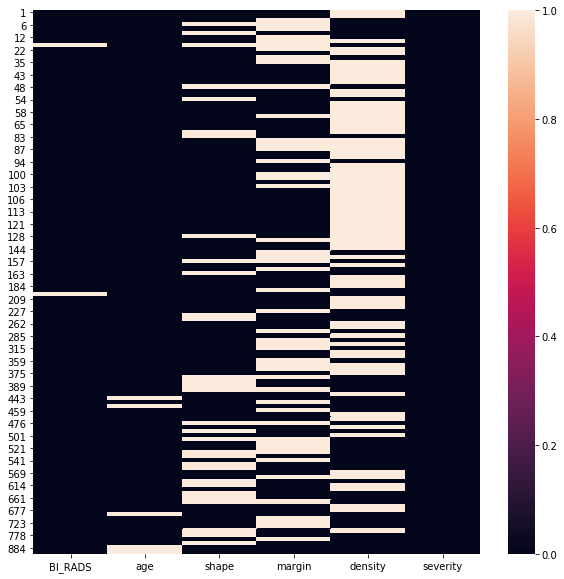

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(testResultsNaNsBoolDF)

C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


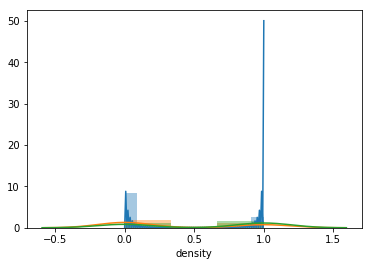

In [15]:
# Udemy_DataScience_Visualization - Section8Lecture50_CombiningPlots
sns.distplot(testResultsNaNsBoolDF['shape'])
sns.distplot(testResultsNaNsBoolDF['margin'])
sns.distplot(testResultsNaNsBoolDF['density'])

In [ ]:
"""
If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().
"""

In [16]:
testResultsCleanDF = testResultsDF.dropna()

In [17]:
testResultsCleanDF = testResultsCleanDF.astype(int)
testResultsCleanDF.head()

,BI_RADS,age,shape,margin,density,severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


In [ ]:
"""
Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create
an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another
array that contains the classes (severity). You'll also need an array of the feature name labels.
"""

In [18]:
list(testResultsCleanDF)

['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity']

In [19]:
# https://www.udemy.com/data-science-and-machine-learning-with-python-hands-on/learn/lecture/4020578

features = list(testResultsCleanDF.columns[1:5])
classes = testResultsCleanDF['severity']
labels = list(testResultsCleanDF)

In [20]:
features

['age', 'shape', 'margin', 'density']

In [21]:
dataArr=testResultsCleanDF.values
featuresArr = np.array(features)
classesArr = np.array(classes)
labelsArr = np.array(labels)

In [22]:
print(dataArr.shape)
print(type(dataArr))

(830, 6)
<class 'numpy.ndarray'>


In [80]:
print(dataArr)

[[ 5 67  3  5  3  1]
 [ 5 58  4  5  3  1]
 [ 4 28  1  1  3  0]
 ...
 [ 4 64  4  5  3  0]
 [ 5 66  4  5  3  1]
 [ 4 62  3  3  3  0]]


In [ ]:
"""
From course review:
all_features = masses_data[['age', 'shape',
                             'margin', 'density']].values


all_classes = masses_data['severity'].values
"""

In [89]:
# review step
featureArr2 = testResultsCleanDF[['age', 'shape',
                             'margin', 'density']].values
classesArr2 = testResultsCleanDF['severity']
print(featureArr2)

[[67  3  5  3]
 [58  4  5  3]
 [28  1  1  3]
 ...
 [64  4  5  3]
 [66  4  5  3]
 [62  3  3  3]]


In [ ]:
"""
Some of our models require the input data to be normalized, so go ahead and normalize the attribute data.
Hint: use preprocessing.StandardScaler().
"""

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
print(scaler.fit(dataArr))

StandardScaler(copy=True, with_mean=True, with_std=True)


C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [88]:
# review step
scaler2 = StandardScaler()
scaledFeatures = scaler2.fit_transform(featureArr2)
scaledFeatures

C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

In [ ]:
# Now create a DecisionTreeClassifier and fit it to your training data.

In [ ]:
# Decision tree

In [24]:
testSplit = 0.25
trainSplit = (1-testSplit)

In [25]:
y = classes
X = testResultsCleanDF[features]

In [26]:
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(830, 4)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSplit, random_state=42)

In [95]:
# review step
np.random.seed(1234)

X_train2, X_test2, y_train2, y_test2 = train_test_split(scaledFeatures, classesArr2, test_size=testSplit, random_state=1)

In [28]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X,y)

In [96]:
# review step
clf_tree2 = tree.DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
clf_tree2 = clf_tree2.fit(X_train2, y_train2)

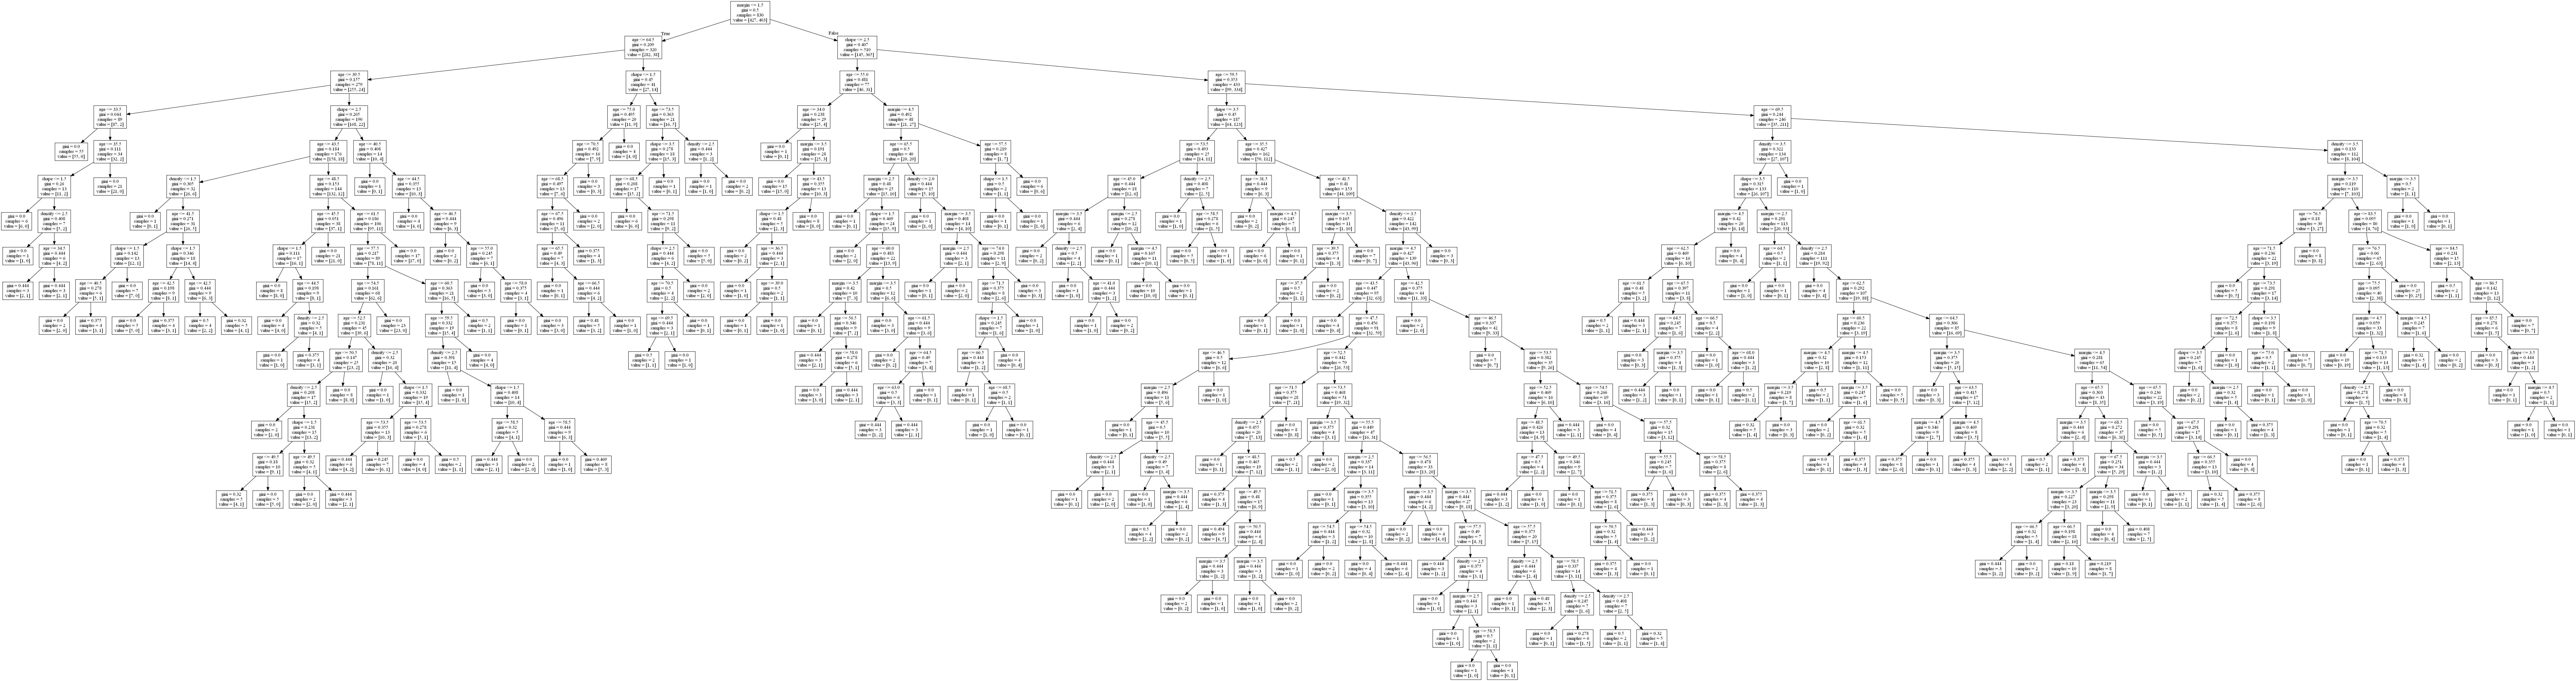

In [29]:
dot_data = StringIO()  
tree.export_graphviz(clf_tree, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

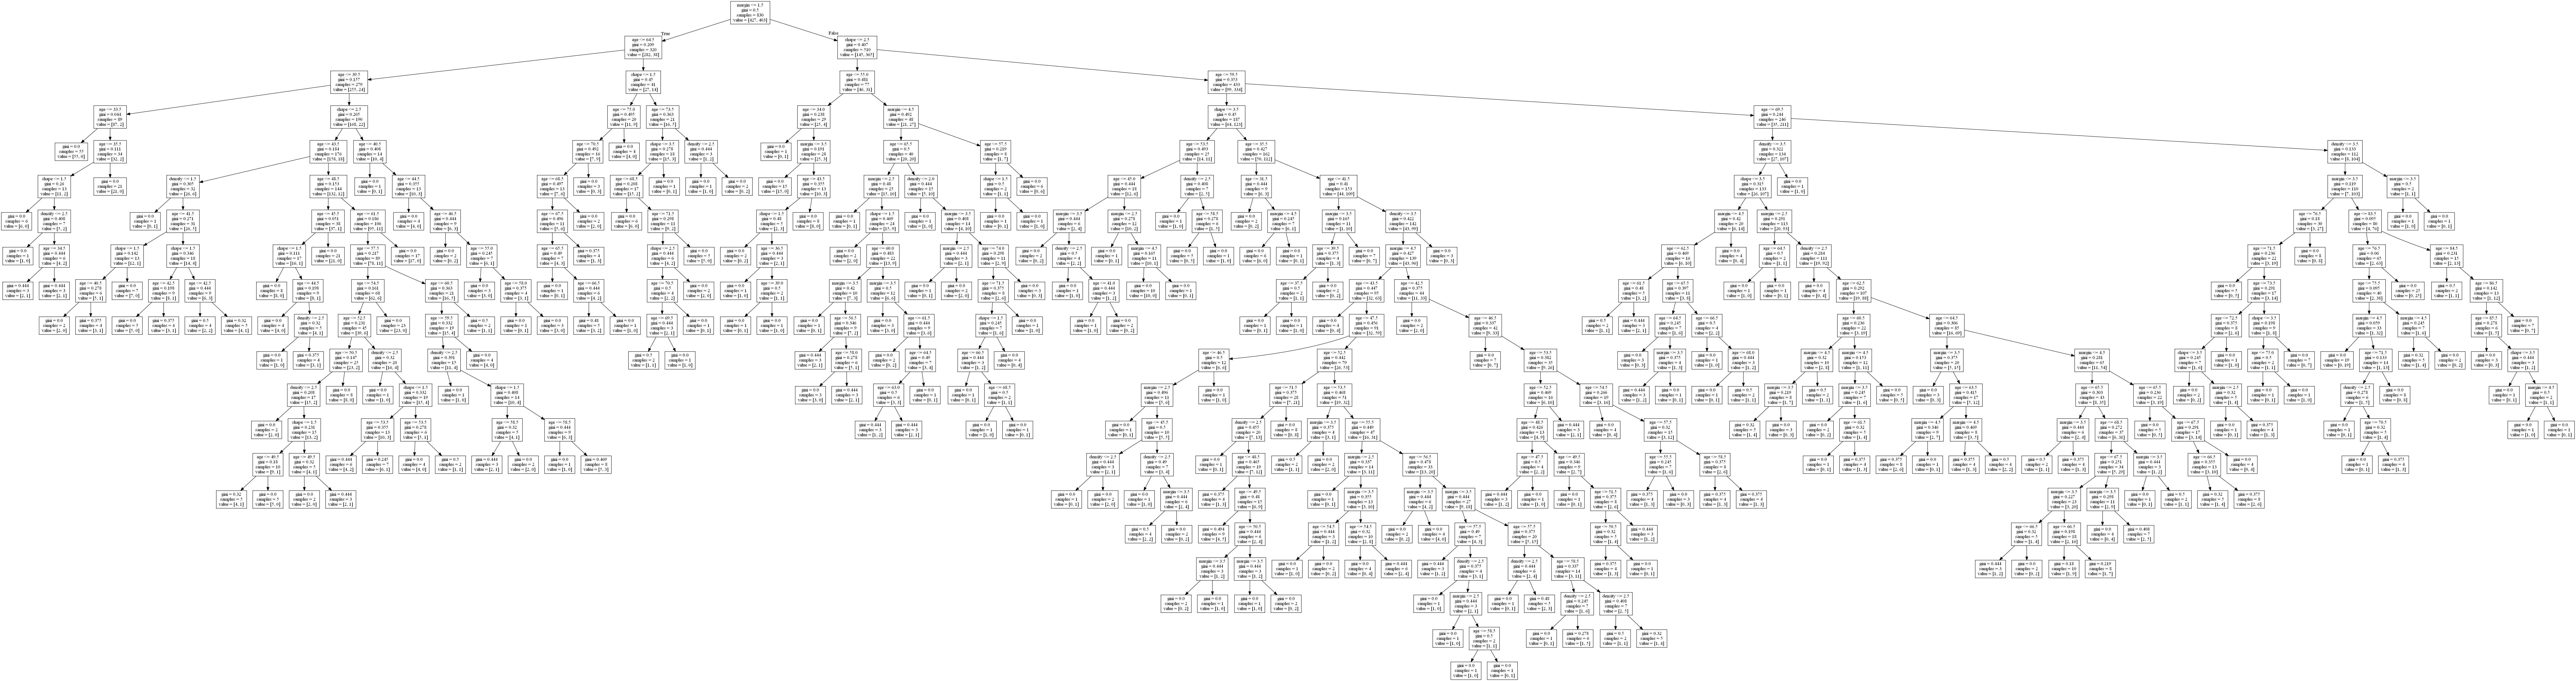

In [97]:
# review step
dot_data2 = StringIO()  
tree.export_graphviz(clf_tree2, out_file=dot_data2,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [30]:
# https://www.geeksforgeeks.org/decision-tree-implementation-python/

# Function to make predictions 
def prediction(X_test, clf_object): 
  
    y_pred = clf_object.predict(X_test) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    score = accuracy_score(y_test,y_pred)*100
    return score

# y_pred = clf.predict(X_test)
# score = accuracy_score(y_test,y_pred)*100
y_pred = prediction(X_test, clf_tree)
score = cal_accuracy(y_test, y_pred)

In [98]:
# review step
y_pred2 = prediction(X_test2, clf_tree2)
score2 = cal_accuracy(y_test2, y_pred2)

In [31]:
print(score)

93.26923076923077


In [99]:
# review step
print(score2)

73.5576923076923


In [ ]:
"""
Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your
model's accuracy (K=10). Hint: use model_selection.cross_val_score
"""

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html:
scores = cross_val_score(clf_tree, X, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all 5 folds:
print(scores.mean())

[0.71428571 0.77380952 0.73809524 0.73493976 0.77108434 0.68674699
 0.72289157 0.76829268 0.76829268 0.68292683]
0.7361365321914837


In [100]:
# review step
scores = cross_val_score(clf_tree2, scaledFeatures, classesArr2, cv=10)
print(scores)
print(scores.mean())

[0.71428571 0.76190476 0.73809524 0.73493976 0.78313253 0.69879518
 0.72289157 0.76829268 0.75609756 0.69512195]
0.7373556945552244


In [ ]:
# Now try a RandomForestClassifier instead. Does it perform better?
# random forest

In [33]:
clf_RF = RandomForestClassifier(n_estimators=10)
clf_RF = clf_RF.fit(X, y)

#Predict malignancy in 70yo with shape margin and density = 3
print (clf_RF.predict([[70, 3, 3, 3]]))
#...and in 70yo with shape margin and density = 1
print (clf_RF.predict([[70, 1, 1, 1]]))

[1]
[0]


In [34]:
y_pred = prediction(X_test, clf_RF)
score = cal_accuracy(y_test, y_pred)

In [35]:
print(score)

92.3076923076923


In [ ]:
# Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [36]:
clf_SVC = svm.SVC(kernel='linear', degree=5, C=1).fit(X_train, y_train)
scores = cross_val_score(clf_SVC, X, y, cv=5)
print(scores)
print(scores.mean())

[0.74251497 0.84431138 0.77108434 0.80606061 0.81212121]
0.7952185005673209


In [101]:
# review step
C = 1.0
clf_SVC2 = svm.SVC(kernel='linear', C=C)

In [103]:
# review step
cv_scores2 = cross_val_score(clf_SVC2, scaledFeatures, classesArr2, cv=10)
cv_scores2.mean()

0.7964988875362076

In [ ]:
# K nearest neighbours

In [ ]:
"""
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than
implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is
an example of a hyperparameter - a parameter on the model itself which may need to be tuned
for best results on your particular data set.

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write
a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial
difference. Make a note of the best performance you could get out of KNN.
"""

In [37]:
pca = PCA(n_components=2, whiten=True).fit(X) # whiten is normalize
X_pca = pca.transform(X)

In [38]:
print(pca.components_)
# Let's see how much information we've managed to preserve:
print(pca.explained_variance_ratio_) # shows how much of the original variance is perserved
# Preserve variance to preserve differentiation between data points and general character of the data
print(sum(pca.explained_variance_ratio_))

[[ 0.99843306  0.03257133  0.04548545  0.00126798]
 [ 0.05595439 -0.59167977 -0.80393421 -0.02177043]]
[0.98424958 0.01295367]
0.997203256835024


In [54]:
type(pca)

sklearn.decomposition.pca.PCA

In [56]:
X_pca.shape

(830, 2)

In [39]:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

# instantiate learning model (k = 3)
clf_knn = KNeighborsClassifier(n_neighbors=5)

# fitting the model
clf_knn.fit(X_train, y_train)

# predict the response
pred = clf_knn.predict(X_test)

# evaluate accuracy
print (accuracy_score(y_test, pred))

0.8076923076923077


In [40]:
upperRangeLimit = 50

resultsDic = dict()

for i in range(1,upperRangeLimit):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    resultsDic.update({i:accuracy_score(y_test, pred)})

In [41]:
print(resultsDic)

{1: 0.75, 2: 0.7067307692307693, 3: 0.8076923076923077, 4: 0.7692307692307693, 5: 0.8076923076923077, 6: 0.7788461538461539, 7: 0.8028846153846154, 8: 0.7884615384615384, 9: 0.7884615384615384, 10: 0.7932692307692307, 11: 0.8028846153846154, 12: 0.8028846153846154, 13: 0.8076923076923077, 14: 0.8125, 15: 0.8221153846153846, 16: 0.8028846153846154, 17: 0.8125, 18: 0.8125, 19: 0.8076923076923077, 20: 0.8076923076923077, 21: 0.7980769230769231, 22: 0.8076923076923077, 23: 0.8028846153846154, 24: 0.7788461538461539, 25: 0.7932692307692307, 26: 0.7980769230769231, 27: 0.7980769230769231, 28: 0.7788461538461539, 29: 0.7788461538461539, 30: 0.7836538461538461, 31: 0.7836538461538461, 32: 0.7740384615384616, 33: 0.7740384615384616, 34: 0.7788461538461539, 35: 0.7884615384615384, 36: 0.7740384615384616, 37: 0.7836538461538461, 38: 0.7836538461538461, 39: 0.7884615384615384, 40: 0.7788461538461539, 41: 0.7884615384615384, 42: 0.7740384615384616, 43: 0.7836538461538461, 44: 0.7836538461538461, 45

In [43]:
# https://stackoverflow.com/questions/42044090/return-the-maximum-value-from-a-dictionary
max_value = max(resultsDic.values())  # maximum value
max_keys = [k for k, v in resultsDic.items() if v == max_value] # getting all keys containing the `maximum`

print(max_value, max_keys)

0.8221153846153846 [15]


In [104]:
# review step
clf_knn2 = KNeighborsClassifier(n_neighbors=10)
cv_scores = cross_val_score(clf_knn2, scaledFeatures, classesArr2, cv=10)

cv_scores.mean()

0.7854795488574507

In [ ]:
"""
Naive Bayes
Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use
MinMaxScaler to get the features in the range MultinomialNB requires.
"""

In [45]:
# https://www.ritchieng.com/machine-learning-feature_engineering_scaling/
# https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/

clf_MnNB = MultinomialNB()

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

clf_MnNB.fit(rescaledX, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
scores = cross_val_score(clf_MnNB, X, y, cv=5)
print(scores)
print(scores.mean())

[0.73053892 0.79041916 0.74698795 0.72121212 0.79393939]
0.7566195101582159


In [105]:
# review step

clf_MnNB2 = MultinomialNB()

scaler2 = MinMaxScaler()
featureArr2_minmax = scaler2.fit_transform(featureArr2)

cv_scores = cross_val_score(clf_MnNB2, featureArr2_minmax, classesArr2, cv=10)

cv_scores.mean()

C:\Users\ianda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0.7844055665169388

In [ ]:
"""
Revisiting SVM
svm.SVC may perform differently with different kernels. The choice of kernel is an example
of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing
kernel is. Do we have a new winner?
"""

In [48]:
clf_SVC2 = svm.SVC(kernel='linear', degree=5, C=1).fit(X_train, y_train)
scores = cross_val_score(clf_SVC2, X, y, cv=5)
print(scores)
print(scores.mean())

[0.74251497 0.84431138 0.77108434 0.80606061 0.81212121]
0.7952185005673209


In [49]:
clf_SVC2 = svm.SVC(kernel='linear', gamma=2).fit(X_train, y_train)
scores = cross_val_score(clf_SVC2, X, y, cv=5)
print(scores)
print(scores.mean())

[0.74251497 0.84431138 0.77108434 0.80606061 0.81212121]
0.7952185005673209


In [50]:
clf_SVC2 = svm.SVC(kernel='poly', gamma=2).fit(X_train, y_train)
scores = cross_val_score(clf_SVC2, X, y, cv=5)
print(scores)
print(scores.mean())

[0.74850299 0.83233533 0.75903614 0.77575758 0.80606061]
0.7843385299499578


In [ ]:
#scoreCard = dict()

#for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
#    clf_SVC2 = svm.SVC(kernel=kernel, degree=5, C=1).fit(X_train, y_train)
#    scores = cross_val_score(clf_SVC2, X, y, cv=5)
#    scoreCard.update({kernel:scores.mean()})

#print(scoreCard)

In [51]:
clf_SVC2 = svm.SVC(kernel='rbf', gamma=2).fit(X_train, y_train)
scores = cross_val_score(clf_SVC2, X, y, cv=5)
print(scores)
print(scores.mean())

[0.74251497 0.80239521 0.71686747 0.73939394 0.70909091]
0.7420524996010169


In [52]:
clf_SVC2 = svm.SVC(kernel='sigmoid', gamma=2).fit(X_train, y_train)
scores = cross_val_score(clf_SVC2, X, y, cv=5)
print(scores)
print(scores.mean())

[0.51497006 0.51497006 0.51204819 0.51515152 0.51515152]
0.5144582685669187


In [106]:
# review step

C = 1.0
clf_SVC3 = svm.SVC(kernel='rbf', C=C)
cv_scores = cross_val_score(clf_SVC3, scaledFeatures, classesArr2, cv=10)
cv_scores.mean()

0.8012023704574396

In [107]:
# review step

C = 1.0
clf_SVC3 = svm.SVC(kernel='sigmoid', C=C)
cv_scores = cross_val_score(clf_SVC3, scaledFeatures, classesArr2, cv=10)
cv_scores.mean()

0.7351055791108685

In [108]:
# review step

C = 1.0
clf_SVC3 = svm.SVC(kernel='poly', C=C)
cv_scores = cross_val_score(clf_SVC3, scaledFeatures, classesArr2, cv=10)
cv_scores.mean()

0.792753942599667

In [ ]:
"""
Logistic Regression
We've tried all these fancy techniques, but fundamentally this is just a binary classification
problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.
"""

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

solverChoice = ['newton-cg', 'sag', 'saga', 'lbfgs']
clf_LogReg = LogisticRegression(random_state=None, solver=solverChoice[3], multi_class='multinomial').fit(X, y)
scores = cross_val_score(clf_LogReg, X, y, cv=5)
print(scores)
print(scores.mean())

[0.76047904 0.83832335 0.77108434 0.80606061 0.83636364]
0.8024621949966442


In [109]:
# review step
clf_LogReg2 = LogisticRegression()
cv_scores = cross_val_score(clf_LogReg2, scaledFeatures, classesArr2, cv=10)
cv_scores.mean()

0.8073583532737221

In [ ]:
# Keras CNN

In [67]:
r_cols2 = ['age', 'shape', 'margin', 'density', 'severity']
testResultsDF2 = pd.read_csv(dataFile, na_values=['?'], names=r_cols,usecols=r_cols2)
testResultsDF2.head()

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


In [68]:
testResultsCleanDF2 = testResultsDF2.dropna()

In [69]:
testResultsCleanDF2.head()

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1


In [62]:
# https://github.com/apoorva-dave/MammographicMassClassification
label = [labels[5]]
print(features)
print(label)

['age', 'shape', 'margin', 'density']
['severity']


In [71]:
X = testResultsCleanDF2[features].values
y = testResultsCleanDF2[label].values
#y = y.ravel()

In [72]:
scalerStd  = StandardScaler()
X = scalerStd.fit_transform(X)
X

array([[ 0.76580356,  0.17445989,  1.39563127,  0.24031298],
       [ 0.15166622,  0.97988304,  1.39563127,  0.24031298],
       [-1.89545824, -1.43638642, -1.15892729,  0.24031298],
       ...,
       [ 0.56109111,  0.97988304,  1.39563127,  0.24031298],
       [ 0.69756608,  0.97988304,  1.39563127,  0.24031298],
       [ 0.42461615,  0.17445989,  0.11835199,  0.24031298]])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSplit, random_state=0)

In [75]:
model = Sequential()
model.add(Dense(64,input_dim=4,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal',activation='sigmoid'))

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [78]:
history = model.fit(X_train,y_train,batch_size=10,epochs=100,verbose=2)

Epoch 1/100
 - 0s - loss: 8.1860 - acc: 0.4815
Epoch 2/100
 - 0s - loss: 8.1559 - acc: 0.4831
Epoch 3/100
 - 0s - loss: 8.3218 - acc: 0.4735
Epoch 4/100
 - 0s - loss: 8.2495 - acc: 0.4783
Epoch 5/100
 - 0s - loss: 8.2121 - acc: 0.4815
Epoch 6/100
 - 0s - loss: 8.2613 - acc: 0.4767
Epoch 7/100
 - 0s - loss: 8.3947 - acc: 0.4655
Epoch 8/100
 - 0s - loss: 8.2299 - acc: 0.4751
Epoch 9/100
 - 0s - loss: 8.1630 - acc: 0.4799
Epoch 10/100
 - 0s - loss: 8.2101 - acc: 0.4735
Epoch 11/100
 - 0s - loss: 8.3450 - acc: 0.4575
Epoch 12/100
 - 0s - loss: 8.2209 - acc: 0.4671
Epoch 13/100
 - 0s - loss: 7.9310 - acc: 0.4815
Epoch 14/100
 - 0s - loss: 8.1232 - acc: 0.4735
Epoch 15/100
 - 0s - loss: 8.0867 - acc: 0.4687
Epoch 16/100
 - 0s - loss: 8.0151 - acc: 0.4880
Epoch 17/100
 - 0s - loss: 7.9835 - acc: 0.4783
Epoch 18/100
 - 0s - loss: 8.1548 - acc: 0.4687
Epoch 19/100
 - 0s - loss: 8.0829 - acc: 0.4751
Epoch 20/100
 - 0s - loss: 8.1316 - acc: 0.4783
Epoch 21/100
 - 0s - loss: 7.9353 - acc: 0.4767
E

In [79]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1545759439468384
Test accuracy: 0.8028846153846154


In [110]:
# review step

def create_model():
    model = Sequential()
    #4 feature inputs going into an 6-unit layer (more does not seem to help - in fact you can go down to 4)
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; adam seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [111]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
cv_scores = cross_val_score(estimator, scaledFeatures, classesArr2, cv=10)
cv_scores.mean()

0.8012048189180444